### Why permutation feature importance

- Shuffling the data variables iteratively, which disrupts the time series order
- A decrease in performance on the altered data can indicate a more important feature
- This approach allows us to appropriately rank each feature in order of importance

### The purpose of this Notebook is to train an appropriately fitted LSTM MODEL on ALL FEATURES in the data and then use it determine importance of features. 

### WHY CHOOSE LSTMs. 

- One huge advantage of using LSTMs is that we do not require to find model parameters like traditional time series models such as `ARIMA` does. 
- Moreover, according to literature it is better at learning complex relationships in the data. 
- Specifically great for multivariate time series modelling.
- Multi-step predictions are possible without using a recursive model or forgoing the use of immideate lags. 
- We also note that they do a better job at making Long Term Predictions
- BETTER THAN OTHER RNNs based on as it handles `VANISHING AND EXPLODING GRADIENTS` better. 

#### Setting up our connections with Google drive. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



%cd /gdrive/My Drive/CCI Case study/

Mounted at /gdrive
/gdrive/My Drive/CCI Case study


### Importing the required packages

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

### Define some helper functions.

In [ ]:
def create_sequences(data, lookback_period, forecast_window):
  ''' 
  Creating Sequences of data, in such a way that we can input it
   into the LSTM architecture

   Inputs:
    data: the dataset for which we want to create the sequences for
    lookback_periods: how many data points the model should look back at
    forecasting window: how much into the future we want to make predictions

  Outputs:
    X and y arrays
  '''

  X = []
  y = []
  for i in range(lookback_period, len(data)-forecast_window):
      X.append(data[i-lookback_period:i, :])
      y.append(data[i:i+forecast_window, 0])
  X, y = np.array(X), np.array(y)
  return X, y

In [ ]:
def loss(preds, val):
  return np.mean(np.mean((preds-val)**2, axis=1))

## <font color='#FBD5AB'>Feature Selection using the model with FUTURE PRICES</font>

### Loading our dataset and preprocess the data.
- SPLITTING THE DATA (train, validation and test)
- DIFFERENCING AND NORMALIZING

In [ ]:
# Load data
data = pd.read_csv('Data for Modelling.csv', index_col=1)
data = data.iloc[:, 1:]

constant_cols = [
    'D:AE:AED:A',
    'GASREGCOVW',
    'FFER', 
    'Total OPEC Production',
    'OPEC Total Surplus Crude Oil Production Capacity',
    'Total World Liquid Fuels Consumption', 
    'Saudi Arabia Crude Oil Production',
    'OPEC Total Crude Oil Production',
    'OPEC Total Crude Oil Production Capacity',
    'Total non-OPEC Liquids Petroleum Production',
    'Total OECD Liquid Fuels Consumption',
    'Total non-OECD Liquid Fuels Consumption',
    'WUIGLOBALWEIGHTAVG',
    'HCPI',
    'EPI',
    'GDP_WORLD'
]

varying_cols = [
    i for i in data.columns if i not in constant_cols
]


# determine train test split sizes
model_data = data.copy()
train_size = int(len(model_data) * 0.7)
val_size = int(len(model_data) * 0.2)
test_size = len(model_data) - train_size - val_size

# split the data
train_data = model_data[:train_size]
val_data = model_data[train_size:train_size+val_size]
test_data = model_data[train_size+val_size:]



### split the varying and constant cols
train_data_varying = train_data[varying_cols]
val_data_varying = val_data[varying_cols]
test_data_varying = test_data[varying_cols]

train_data_constant = train_data[constant_cols]
val_data_constant = val_data[constant_cols]
test_data_constant = test_data[constant_cols]



## Stationarize the varying cols
train_data_diff = train_data_varying.diff().dropna()
val_data_diff = val_data_varying.diff().dropna()
test_data_diff = test_data_varying.diff().dropna()

## add the constant cols
train_data_diff = pd.merge(train_data_diff, train_data_constant, how='left', left_index=True, right_index=True)
val_data_diff = pd.merge(val_data_diff, val_data_constant, how='left', left_index=True, right_index=True)
test_data_diff = pd.merge(test_data_diff, test_data_constant, how='left', left_index=True, right_index=True)



## ensure uniformity by dropping the first row of the actual untouched data so sequqences can be formed easily
train_data = train_data[1:]
val_data = val_data[1:]
test_data = test_data[1:]



_, actual_train_y = create_sequences(train_data.values, 20, 7)
_, actual_val_y = create_sequences(val_data.values, 20, 7)
_, actual_test_y = create_sequences(test_data.values, 20, 7)


# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data_diff)
val_data_scaled = scaler.transform(val_data_diff)
test_data_scaled = scaler.transform(test_data_diff)

train_X, train_y = create_sequences(train_data_scaled, 20, 7)
val_X, val_y = create_sequences(val_data_scaled, 20, 7)
test_X, test_y = create_sequences(test_data_scaled, 20, 7)

#### Define a model that we know that performs well on the validation data (in terms of loss convergence).

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(20, 21), return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(7))

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
model.fit(train_X, train_y, epochs=200, batch_size=64, validation_data=(val_X, val_y), verbose=0)


### Measure the decrease in Performance after shuffling each variable.

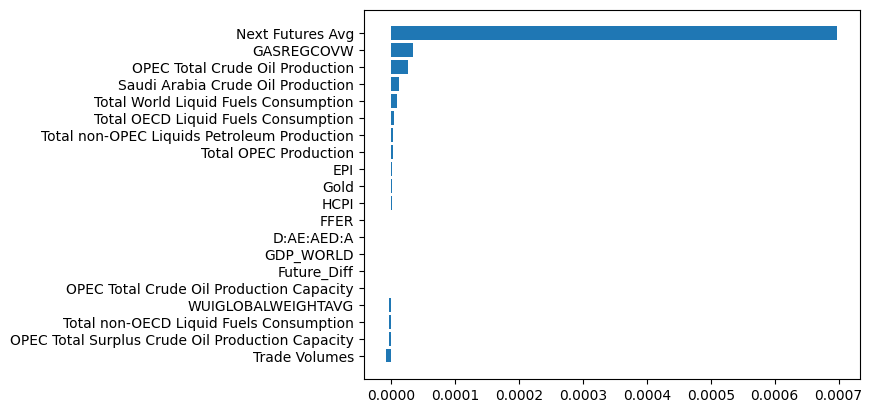

In [ ]:
## Make predictions and compute the base loss function.
val_preds = model.predict(val_X, verbose=0)
mae = loss(val_y, val_preds)

### create a dictionary 
index_cols = {i:val_data_diff.columns[i] for i in range(val_X.shape[2]) if i > 0}
importance = {}
for i in range(1, val_X.shape[2]):
  new_data = val_data_scaled.copy()
  new_data[:, i] = shuffle(new_data[:, i])
  alt_X, alt_y = create_sequences(new_data, 20, 7)
  alt_pred = model.predict(alt_X, verbose=0)
  alt_loss = loss(alt_pred, alt_y)
  importance_loss = alt_loss - mae
  importance[index_cols[i]] = importance_loss

importance = pd.DataFrame(importance.items(), columns=['Features', 'Importance'])
feature_importance = importance.sort_values(by='Importance')


plt.barh(feature_importance['Features'], feature_importance['Importance'])
plt.show()

## <font color='#FBD5AB'>Feature Selection from Model Without Using FUTURE PRICES</font>

#### Repeat the same steps. 

In [ ]:
# Load data
data = pd.read_csv('Data for Modelling.csv', index_col=1)
data = data.iloc[:, 1:]
data = data.drop(columns= ['Next Futures Avg'])

constant_cols = [
    'D:AE:AED:A',
    'GASREGCOVW',
    'FFER', 
    'Total OPEC Production',
    'OPEC Total Surplus Crude Oil Production Capacity',
    'Total World Liquid Fuels Consumption', 
    'Saudi Arabia Crude Oil Production',
    'OPEC Total Crude Oil Production',
    'OPEC Total Crude Oil Production Capacity',
    'Total non-OPEC Liquids Petroleum Production',
    'Total OECD Liquid Fuels Consumption',
    'Total non-OECD Liquid Fuels Consumption',
    'WUIGLOBALWEIGHTAVG',
    'HCPI',
    'EPI',
    'GDP_WORLD'
]

varying_cols = [
    i for i in data.columns if i not in constant_cols
]


# determine train test split sizes
model_data = data.copy()
train_size = int(len(model_data) * 0.7)
val_size = int(len(model_data) * 0.2)
test_size = len(model_data) - train_size - val_size

# split the data
train_data = model_data[:train_size]
val_data = model_data[train_size:train_size+val_size]
test_data = model_data[train_size+val_size:]



### split the varying and constant cols
train_data_varying = train_data[varying_cols]
val_data_varying = val_data[varying_cols]
test_data_varying = test_data[varying_cols]

train_data_constant = train_data[constant_cols]
val_data_constant = val_data[constant_cols]
test_data_constant = test_data[constant_cols]



## Stationarize the varying cols
train_data_diff = train_data_varying.diff().dropna()
val_data_diff = val_data_varying.diff().dropna()
test_data_diff = test_data_varying.diff().dropna()

## add the constant cols
train_data_diff = pd.merge(train_data_diff, train_data_constant, how='left', left_index=True, right_index=True)
val_data_diff = pd.merge(val_data_diff, val_data_constant, how='left', left_index=True, right_index=True)
test_data_diff = pd.merge(test_data_diff, test_data_constant, how='left', left_index=True, right_index=True)



## ensure uniformity by dropping the first row of the actual untouched data so sequqences can be formed easily
train_data = train_data[1:]
val_data = val_data[1:]
test_data = test_data[1:]



_, actual_train_y = create_sequences(train_data.values, 20, 7)
_, actual_val_y = create_sequences(val_data.values, 20, 7)
_, actual_test_y = create_sequences(test_data.values, 20, 7)


# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data_diff)
val_data_scaled = scaler.transform(val_data_diff)
test_data_scaled = scaler.transform(test_data_diff)

train_X, train_y = create_sequences(train_data_scaled, 20, 7)
val_X, val_y = create_sequences(val_data_scaled, 20, 7)
test_X, test_y = create_sequences(test_data_scaled, 20, 7)

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(20, 20), return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(7))

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
model.fit(train_X, train_y, epochs=200, batch_size=64, validation_data=(val_X, val_y), verbose=0)

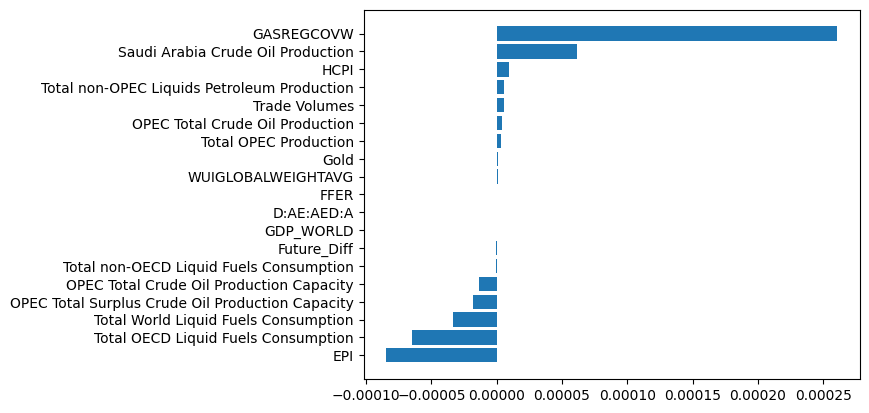

In [ ]:
val_preds = model.predict(val_X, verbose=0)
mae = loss(val_y, val_preds)


index_cols = {i:val_data_diff.columns[i] for i in range(val_X.shape[2]) if i > 0}
importance = {}
for i in range(1, val_X.shape[2]):
  new_data = val_data_scaled.copy()
  new_data[:, i] = shuffle(new_data[:, i])
  alt_X, alt_y = create_sequences(new_data, 20, 7)
  alt_pred = model.predict(alt_X, verbose=0)
  alt_loss = loss(alt_pred, alt_y)
  importance_loss = alt_loss - mae
  importance[index_cols[i]] = importance_loss

importance = pd.DataFrame(importance.items(), columns=['Features', 'Importance'])
feature_importance = importance.sort_values(by='Importance')


plt.barh(feature_importance['Features'], feature_importance['Importance'])
plt.show()